# PROYECTO No 4 INTEGRADOR SERIES DE TIEMPO MODELOS CLASICOS

En este notebook continuaremos con el analisis que se viene desarrollando desde el proyecto No 3 Series de Tiempo con el dataset del Flujo Vehicular de la ciudad de Buenos Aires-Argentina exactamente en la estacion Illia.

En este caso no se realizara filtros por medio de pago se trabajara con todos los medios de pago, tipo de vehiculos, etc. Ademas en este notebook se implementara el desarrollo de modelos clasicos estadisticos y la libreria Prophet, buscando una mejor prediccion para el año 2020.

**Recuerda descargar los dataset con los que vas a trabajar desde [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa).**

**Este notebook lo puedes encontrar en el siguiente repositorio [aquí](https://github.com/Steven030530/proyecto3).**

**Aca te dejo información relevante para la comprension de los modelos clasicos
https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7.**

**Aca te dejo información relevante para la comprension de la libreria Prophet 
https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3.**


## EDA

**Importando Librerias**

Inicialmente importaremos las librerias basicas con las que siempre trabajamos tales como pandas, numpy,matplotlib,etc. más adelante en el desarrollo de este notebook importaremos más funciones especificas para el analisis de las series de tiempo

In [3]:
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
# importamos las librerias mas conocidas durante el desarrollo del notebook iremos importando más.

In [4]:
# importamos los datos de los años 2017-2019
data2017= pd.read_csv("flujo-vehicular-2017.csv")
data2018= pd.read_csv("flujo-vehicular-2018.csv")
data2019= pd.read_csv("flujo-vehicular-2019.csv")

In [5]:
#Concatenamos los datos para convertirlos en un solo Dataframe 
data= pd.concat([data2017,data2018,data2019])
data.reset_index(drop=True, inplace=True)

In [6]:
#Revisamos que los datos se hayan importado de manera correcta 
data.head()

periodo       fecha  hora_inicio  hora_fin      dia estacion sentido  \
0     2017  2017-01-01            0         1  Domingo  Alberdi  Centro   
1     2017  2017-01-01            0         1  Domingo  Alberdi  Centro   
2     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   
3     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   
4     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              25  
1       Liviano    TELEPASE               7  
2       Liviano  NO COBRADO               5  
3       Liviano    EFECTIVO               2  
4       Liviano    EFECTIVO              94

In [93]:
data_r= data.groupby(by="tipo_vehiculo").sum()

In [94]:
data_r.sort_values(by="cantidad_pasos")

periodo  hora_inicio  hora_fin  cantidad_pasos
tipo_vehiculo                                                   
Pesado         3761743911     22267199  22549433        36472911
Liviano        3423200305     20294373  20445021       338164796

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

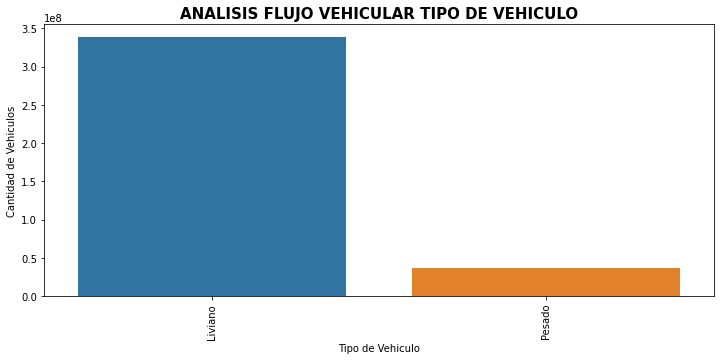

In [102]:
plt.figure(figsize=(12,5))
sns.barplot(x=data_r.index,y="cantidad_pasos",data=data_r)
plt.title("ANALISIS FLUJO VEHICULAR TIPO DE VEHICULO",fontsize=15,fontweight="bold")
plt.xlabel("Tipo de Vehiculo")
plt.ylabel("Cantidad de Vehiculos")
plt.xticks(rotation=90)

En el grafico anterior observamos como el tipo de vehiculo liviano es aquel que más influye en el flujo vehicular de todas las estaciones, tiene mucho sentido ya que el mayor transito siempre lo generan las personas de manera particular los vehiculos pesados no tienen tanta demanda sino por temas de tipo empresarial.

In [7]:
# Desarrollamos una funcion que logre realizar todos los cambios 
# y filtros que requieren los datos para analizarlos de acuerdo a la estacion que elijamos

def Transformacion_data(estacion):
    mask= data["estacion"]==estacion
    station1=data[mask]
    station1.fecha= pd.to_datetime(station1.fecha,dayfirst=True)
    diario= station1.resample("D",on="fecha").sum()
    diario.drop(columns=["periodo","hora_inicio","hora_fin"],inplace=True)
    
    return diario

In [8]:
#Utilizamos la estacion Illia para comparar los modelos de Machine Learning vs Modelos Autorregresivos
diario=Transformacion_data("Illia")

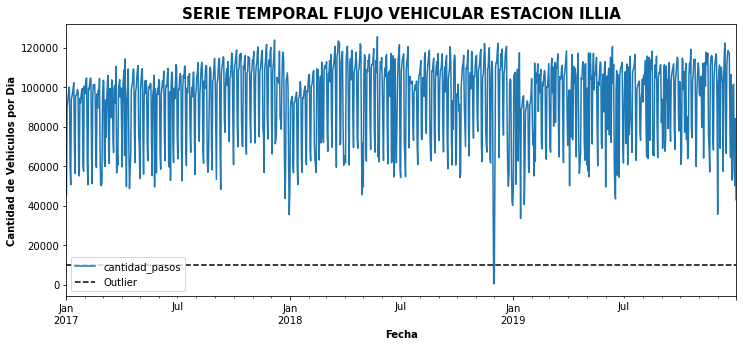

In [9]:
# Graficamos el comportamiento de la serie de tiempo en dicha estacion
diario.plot(figsize=(12,5))
plt.title("SERIE TEMPORAL FLUJO VEHICULAR ESTACION ILLIA",fontweight="bold",fontsize=15)
plt.xlabel("Fecha",fontweight="bold",fontsize=10)
plt.ylabel("Cantidad de Vehiculos por Dia",fontweight="bold",fontsize=10)
plt.axhline(y=10000,linestyle="--",color="k",label="Outlier")
plt.legend()

* Podemos observar en el grafico anterior que el flujo vehicular en la estacion Illia tiene valores outliers que los hemos identificado con una linea horizontal de color negro, estos valores los trataremos con el fin de que podamos utilizar de una manera adecuada la serie temporal y poder producir un modelo optimo.

* Ademas en el grafico podemos identificar un patron en todos los meses de enero donde se presenta una caida en la serie temporal esto podria deberse a posible temporada vacacional

In [10]:
# Convertimos los valores outlier en valores Faltantes
diario.cantidad_pasos[diario.cantidad_pasos<10000]=np.nan

In [11]:
# Interpolamos la serie para que no hayan valores faltantes
diario= diario.interpolate()

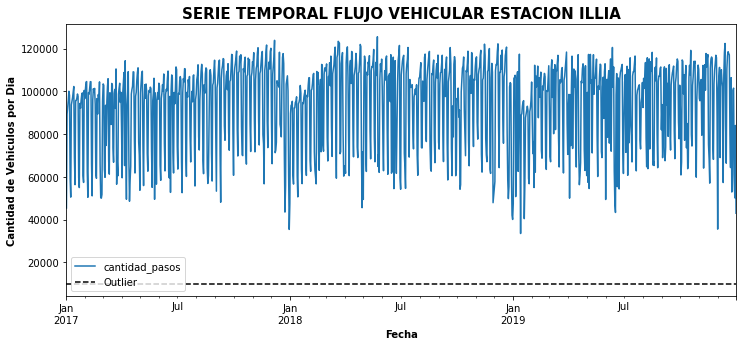

In [12]:
#Graficamos nuevamente la serie
diario.plot(figsize=(12,5))
plt.title("SERIE TEMPORAL FLUJO VEHICULAR ESTACION ILLIA",fontweight="bold",fontsize=15)
plt.xlabel("Fecha",fontweight="bold",fontsize=10)
plt.ylabel("Cantidad de Vehiculos por Dia",fontweight="bold",fontsize=10)
plt.axhline(y=10000,linestyle="--",color="k",label="Outlier")
plt.legend()

* En este grafico se puede evidenciar que hemos solucionado el tema de los valores outliers

# MODELOS AUTORREGRESIVOS - MEDIAS MOVILES

Es hora de aplicar los modelos clasicos para las series temporales, conocidos como modelos autorregresivos y medias moviles, para esto debemos transformar nuestra serie en una serie estacionaria ya que este tipo de modelos funciona de una manera optima con series de este tipo.

In [13]:
# con la funcion pct_change de pandas podemos obtener los retornos de los datos
diario["return_illia"]= diario.pct_change(1)*100

In [14]:
diario.dropna(inplace=True)

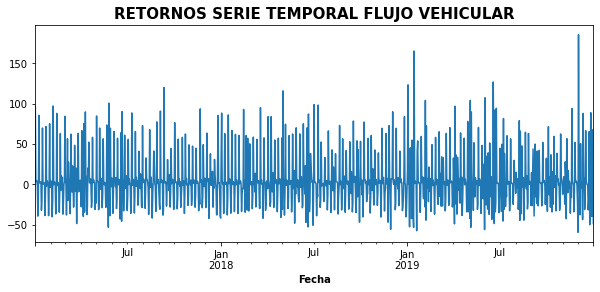

In [15]:
#graficamos los retornos de la serie temporal
diario.return_illia.plot(figsize=(10,4))
plt.title("RETORNOS SERIE TEMPORAL FLUJO VEHICULAR",fontweight="bold",fontsize=15)
plt.xlabel("Fecha",fontweight="bold")
plt.show()

En este grafico podemos deducir un comportamiento similar al ruido blanco, pero para estar seguros de que nuestra serie es estacionaria debemos aplicar el metodo DF(Dickey-Fuller).

In [16]:
#Importamos la funcion adfuller la cual nos dira si nuestra serie es o no  estacionaria
from statsmodels.tsa.stattools import adfuller

In [17]:
result = adfuller(diario.return_illia)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -39.664144
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


Esta prueba nos indica dos resultados para analizar uno es el ADF estadistico y el otro es el P-valor si analizamos ambos valores contra los valores criticos podemos observar que el ADF estadistico -39.6 es menor que los valores criticos como -3.4,-2.8 y -2.5 y si a analizamos el P-valor 0% es menor que el 1%,5% y 10% lo que nos indica que podemos rechazar la hipotesis nula y nos indica que la serie temporal es estacionaria

**AHORA IMPORTAMOS LAS FUNCIONES QUE TRAEN CONSIGO LA IMPLEMENTACION DE MODELOS AUTORREGRESIVOS COMO ARIMA-SARIMAX**


In [18]:
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace import sarimax
import statsmodels.graphics.tsaplots as sgt

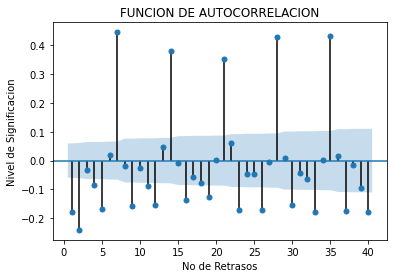

In [19]:
sgt.plot_acf(diario.return_illia,lags=40,zero=False),
plt.title("FUNCION DE AUTOCORRELACION")
plt.xlabel("No de Retrasos")
plt.ylabel("Nivel de Significacion")
plt.show()

En grafico anterior podemos observar la autocorrelacion que posee un periodo de tiempo consigo mismo en un periodo pasado dentro de la misma serie temporal, y podemos identificar el patron que se presenta cada 7 dias, esta funcion analiza las relaciones directas y las relaciones indirectas.

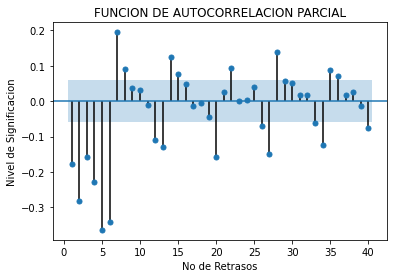

In [20]:
sgt.plot_pacf(diario.return_illia,lags=40,zero=False)
plt.title("FUNCION DE AUTOCORRELACION PARCIAL")
plt.xlabel("No de Retrasos")
plt.ylabel("Nivel de Significacion")
plt.show()

Este grafico a diferencia del anterior analiza solo las relaciones directas y nos muestra que existe un grado de significacion alto de manera negativa, lo que nos indica que cada dia influye de forma negativa al flujo vehicular, lo que quiere decir que cada dia va disminuyendo con respecto al dia anterior hasta que llega al dia septimo donde el patron se repite.

## SET TRAIN Y SET TEST

Ahora separamos nuestro conjunto de datos en datos de entrenamiento y datos de testeo para la aplicacion de nuestros modelos

In [21]:
#Seleccionamos el tamaño por el cual vamos a separar nuestros datos
# para este caso seleccionamos 2 años
size=730

In [22]:
#Separamos el set de los datos en train y test
train,test= diario.iloc[:size],diario.iloc[size:]

En el siguiente paso implementaremos el Modelo ARMA más sencillo como Modelo Benchmark, para evaluar Modelos más avanzados, para este punto utilizaremos Autorregresivo 1 y Media Movil 1

In [23]:
#Utilizamos ARIMA para crear nuestro modelo en los datos de retorno
model= ARMA(train.return_illia,order=(1,1))

In [24]:
#Entrenamos el modelo con la funcion fit
result=model.fit()

In [25]:
#Verificamos los resultados con la funcion summary 
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           return_illia   No. Observations:                  730
Model:                     ARMA(1, 1)   Log Likelihood               -3449.042
Method:                       css-mle   S.D. of innovations             27.252
Date:                Tue, 24 Nov 2020   AIC                           6906.084
Time:                        09:58:30   BIC                           6924.456
Sample:                    01-02-2017   HQIC                          6913.172
                         - 01-01-2019                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  4.0396      0.167     24.223      0.000       3.713       4.366
ar.L1.return_illia     0.4179      0.040     10.577      0.000       0.340       0.495
ma.L1.return_illia    -0.9049      0.016    -58.322      0.000      -0.935      -0.875
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3927           +0.0000j            2.3927            0.0000
MA.1            1.1050           +0.0000j            1.1050            0.0000
-----------------------------------------------------------------------------
"""

* En este resumen de los datos podemos verificar varios valores importantes podemos observar los coeficientes de autorregresion y medias moviles y podemos determinar por su P valor si el valor es significativo o no, tambien podemos observar el valor Log Likelihood que es la verosimilitud entre más alto sea este valor mejor sera nuestro modelo y tambien podemos observar valores como AIC y BIC que son los valores de informacion de criterios y entre más bajos sean mejor sera nuestro modelo.

In [26]:
#Predecimos sobre los datos de Test
start= len(train)
end= len(train)+len(test)
predictions= result.predict(start=start,end=end).rename("ARMA(1,1)Predictions")

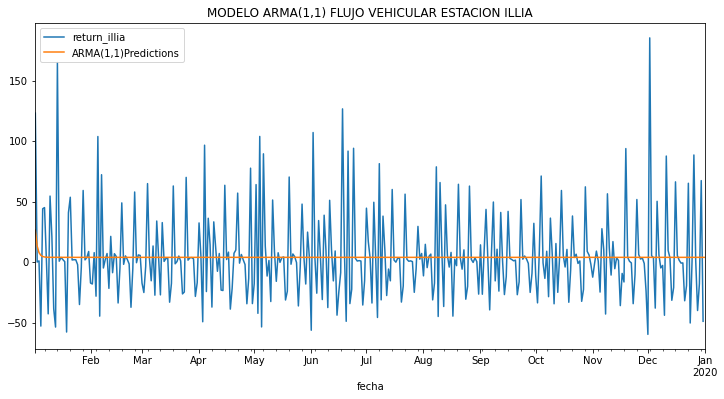

In [27]:
title= "MODELO ARMA(1,1) FLUJO VEHICULAR ESTACION ILLIA"
ax= test.return_illia.plot(legend=True,figsize=(12,6), title=title)
predictions.plot(legend=True)
ax.autoscale(axis="x",tight=True)


En este primer modelo observamos como el modelo más sencillo no logra predecir las variaciones que se presenta dentro de los datos originales.

A continuacion implementamos un modelo ARMA más complejo que nos ayude a mejorar esas predicciones que deseamos obtener en el test.

In [29]:
model_arma= ARMA(endog=train.return_illia,order=(7,5))
resultarma=model_arma.fit()
resultarma.summary()

C:\Users\Asus\miniconda3\envs\ds2020\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\Users\Asus\miniconda3\envs\ds2020\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           return_illia   No. Observations:                  730
Model:                     ARMA(7, 5)   Log Likelihood               -3206.915
Method:                       css-mle   S.D. of innovations             19.319
Date:                Tue, 24 Nov 2020   AIC                           6441.831
Time:                        09:59:33   BIC                           6506.134
Sample:                    01-02-2017   HQIC                          6466.639
                         - 01-01-2019                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  3.9644      0.423      9.362      0.000       3.134       4.794
ar.L1.return_illia    -0.6862      0.001   -752.279      0.000      -0.688      -0.684
ar.L2.return_illia    -0.9141   4.26e-05  -2.14e+04      0.000      -0.914      -0.914
ar.L3.return_illia    -0.9901        nan        nan        nan         nan         nan
ar.L4.return_illia    -0.6245        nan        nan        nan         nan         nan
ar.L5.return_illia    -1.2076        nan        nan        nan         nan         nan
ar.L6.return_illia    -0.5238      0.000  -1691.876      0.000      -0.524      -0.523
ar.L7.return_illia    -0.1742      0.000  -1044.224      0.000      -0.175      -0.174
ma.L1.return_illia     0.1889      0.008     22.342      0.000       0.172       0.205
ma.L2.return_illia     0.6301      0.008     74.974      0.000       0.614       0.647
ma.L3.return_illia     0.6271      0.014     45.912      0.000       0.600       0.654
ma.L4.return_illia     0.1821      0.018      9.847      0.000       0.146       0.218
ma.L5.return_illia     0.9942      0.012     80.732      0.000       0.970       1.018
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6237           -0.7817j            1.0000           -0.1428
AR.2            0.6237           +0.7817j            1.0000            0.1428
AR.3           -0.2225           -0.9749j            1.0000           -0.2857
AR.4           -0.2225           +0.9749j            1.0000            0.2857
AR.5           -1.0013           -0.0000j            1.0013           -0.5000
AR.6           -1.4040           -1.9394j            2.3943           -0.3497
AR.7           -1.4040           +1.9394j            2.3943            0.3497
MA.1           -1.0004           -0.0000j            1.0004           -0.5000
MA.2            0.6298           -0.7802j            1.0026           -0.1419
MA.3            0.6298           +0.7802j            1.0026            0.1419
MA.4           -0.2212           -0.9753j            1.0001           -0.2855
MA.5           -0.2212           +0.9753j            1.0001            0.2855
-----------------------------------------------------------------------------
"""

Analizando el informe anterior podemos ver como la verosimilitud incremento y los criterios de informacion disminuyeron, lo que quiere decir que el performance de nuestro modelo a mejorado.

In [30]:
#Realizamos la prediccion sobre el set de testeo
start= len(train)
end= len(train)+len(test)
predictions= resultarma.predict(start=start,end=end).rename("ARMA(7,5)Predictions")

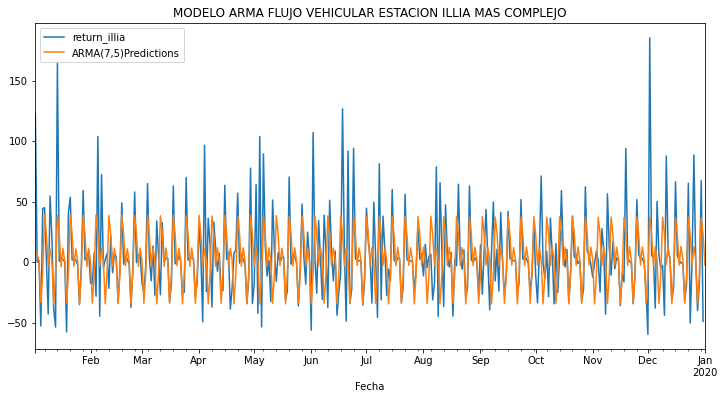

In [31]:
title= "MODELO ARMA FLUJO VEHICULAR ESTACION ILLIA MAS COMPLEJO"
ylabel=""
xlabel="Fecha"

ax= test.return_illia.plot(legend=True,figsize=(12,6), title=title)
predictions.plot(legend=True)
ax.autoscale(axis="x",tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

En este grafico podemos observar como las predicciones se ajustan mejor a los datos reales sin embargo en algunos casos sobreestiman y en otro casos subestiman los valores reales.

## MODELO ARIMA CON INFORMACION EXOGENA

In [36]:
from statsmodels.tsa.arima_model import ARIMA
model_arimax= ARIMA(train.return_illia,order=(10,0,6),exog=train.cantidad_pasos)
# la varible exog dentro del modelo ARIMA nos permite traer informacion externa que ayude
# al modelo a interpretar mejor los valores

In [37]:
result_arimax= model_arimax.fit()

C:\Users\Asus\miniconda3\envs\ds2020\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\Users\Asus\miniconda3\envs\ds2020\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [38]:
result_arimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           return_illia   No. Observations:                  730
Model:                    ARMA(10, 6)   Log Likelihood               -3161.519
Method:                       css-mle   S.D. of innovations             18.213
Date:                Tue, 24 Nov 2020   AIC                           6361.037
Time:                        10:02:41   BIC                           6448.305
Sample:                    01-02-2017   HQIC                          6394.706
                         - 01-01-2019                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -60.3755      6.620     -9.121      0.000     -73.350     -47.401
cantidad_pasos          0.0007   7.06e-05      9.764      0.000       0.001       0.001
ar.L1.return_illia     -1.0649      0.061    -17.535      0.000      -1.184      -0.946
ar.L2.return_illia     -1.0389      0.044    -23.870      0.000      -1.124      -0.954
ar.L3.return_illia     -1.0536      0.051    -20.783      0.000      -1.153      -0.954
ar.L4.return_illia     -0.9496      0.035    -27.235      0.000      -1.018      -0.881
ar.L5.return_illia     -0.9974      0.038    -26.556      0.000      -1.071      -0.924
ar.L6.return_illia     -0.9461      0.035    -27.367      0.000      -1.014      -0.878
ar.L7.return_illia      0.0067      0.036      0.185      0.853      -0.064       0.077
ar.L8.return_illia      0.1044      0.046      2.253      0.024       0.014       0.195
ar.L9.return_illia      0.0682      0.030      2.242      0.025       0.009       0.128
ar.L10.return_illia     0.0712      0.031      2.279      0.023       0.010       0.132
ma.L1.return_illia      0.9763      0.023     43.105      0.000       0.932       1.021
ma.L2.return_illia      0.9468      0.029     32.624      0.000       0.890       1.004
ma.L3.return_illia      0.9802      0.033     29.782      0.000       0.916       1.045
ma.L4.return_illia      0.8657        nan        nan        nan         nan         nan
ma.L5.return_illia      0.9468        nan        nan        nan         nan         nan
ma.L6.return_illia      0.8717        nan        nan        nan         nan         nan
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             0.6239           -0.7817j            1.0001           -0.1428
AR.2             0.6239           +0.7817j            1.0001            0.1428
AR.3            -0.2225           -0.9750j            1.0001           -0.2857
AR.4            -0.2225           +0.9750j            1.0001            0.2857
AR.5            -0.9310           -0.4380j            1.0289           -0.4300
AR.6            -0.9310           +0.4380j            1.0289            0.4300
AR.7            -1.7134           -0.0000j            1.7134           -0.5000
AR.8             1.9573           -0.0000j            1.9573           -0.0000
AR.9            -0.0709           -1.9868j            1.9881           -0.2557
AR.10           -0.0709           +1.9868j            1.9881            0.2557
MA.1             0.6358           -0.7971j            1.0196           -0.1428
MA.2             0.6358           +0.7971j            1.0196            0.1428
MA.3            -0.2220           -0.9833j            1.0080           -0.2853
MA.4            -0.2220           +0.9833j        

In [39]:
start_date= "2019-01-01"
end_date= "2019-12-31"
pred_armax= result_arimax.predict(start=start_date,
                                  end=end_date,
                                  exog=test.cantidad_pasos[start_date:end_date]).rename("Predictions")

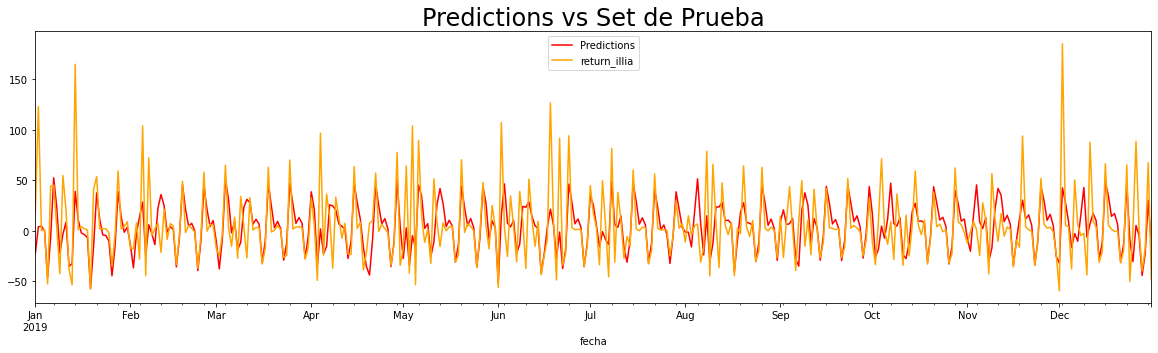

In [40]:
pred_armax[start_date:end_date].plot(figsize=(20,5),color="red")
diario.return_illia[start_date:end_date].plot(color="orange")
plt.title("Predictions vs Set de Prueba", size=24)
plt.legend()
plt.show()

Analizando tanto el informe como el grafico podemos observar una mejoria leve ya que al incluir una variable exogena al modelo tiende a mejorar un poco el criterio de informacion y el indice de verosimilitud.

## MODELO SARIMAX CON INFORMACION ESTACIONAL E INFORMACION EXOGENA

In [48]:
modelo_sarimax= sarimax.SARIMAX(train.return_illia,order=(6,0,4),seasonal_order=(4,0,1,7),
                                exog=train.cantidad_pasos)

In [49]:
result_sarimax=modelo_sarimax.fit()

In [50]:
result_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                        return_illia   No. Observations:                  730
Model:             SARIMAX(6, 0, 4)x(4, 0, [1], 7)   Log Likelihood               -3253.557
Date:                             Tue, 24 Nov 2020   AIC                           6541.115
Time:                                     10:04:36   BIC                           6619.197
Sample:                                 01-02-2017   HQIC                          6571.239
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
cantidad_pasos  5.438e-05   3.05e-05      1.782      0.075   -5.42e-06       0.000
ar.L1             -0.5627      0.199     -2.826      0.005      -0.953      -0.172
ar.L2             -0.9439      0.119     -7.937      0.000      -1.177      -0.711
ar.L3             -0.6627      0.200     -3.311      0.001      -1.055      -0.270
ar.L4             -0.8864      0.129     -6.845      0.000      -1.140      -0.633
ar.L5             -0.6174      0.101     -6.123      0.000      -0.815      -0.420
ar.L6             -0.4195      0.116     -3.617      0.000      -0.647      -0.192
ma.L1              0.0381      0.195      0.195      0.845      -0.344       0.420
ma.L2              0.4058      0.135      3.006      0.003       0.141       0.670
ma.L3              0.0533      0.165      0.323      0.747      -0.271       0.377
ma.L4              0.4113      0.111      3.696      0.000       0.193       0.629
ar.S.L7            0.2535      0.202      1.255      0.210      -0.142       0.649
ar.S.L14           0.2116      0.079      2.688      0.007       0.057       0.366
ar.S.L21           0.1736      0.075      2.323      0.020       0.027       0.320
ar.S.L28           0.2089      0.058      3.610      0.000       0.096       0.322
ma.S.L7           -0.0768      0.226     -0.339      0.735      -0.521       0.367
sigma2           536.9042     26.218     20.478      0.000     485.517     588.291
===================================================================================
Ljung-Box (Q):                      131.42   Jarque-Bera (JB):               268.41
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                            -0.16
Prob(H) (two-sided):                  0.28   Kurtosis:                         5.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [51]:
start_date= "2019-01-01"
end_date= "2019-12-31"
pred_sarimax= result_sarimax.predict(start=start_date,
                                  end=end_date,
                                  exog=test.cantidad_pasos[start_date:end_date]).rename("Predictions")

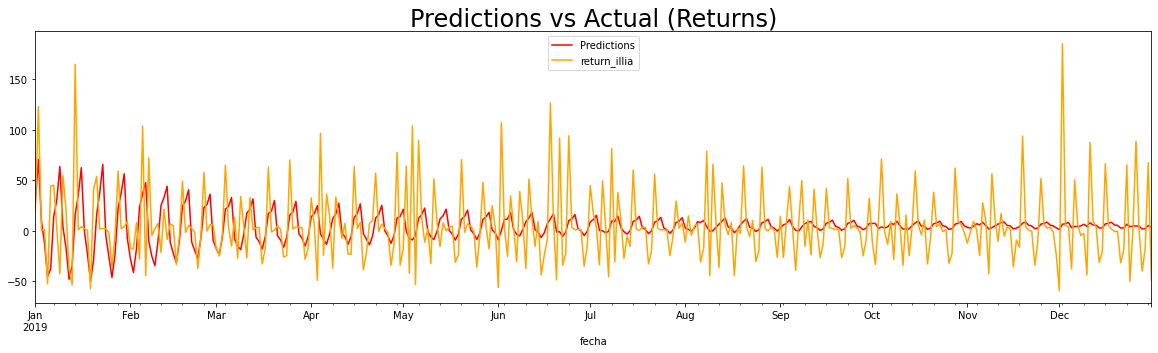

In [52]:
pred_sarimax[start_date:end_date].plot(figsize=(20,5),color="red")
diario.return_illia[start_date:end_date].plot(color="orange")
plt.title("Predictions vs Actual (Returns)", size=24)
plt.legend()
plt.show()

En este grafico podemos analizar como atraves de la serie temporal la prediccion va perdiendo la variacion y la grafica va adquiriendo una forma como de suavizado lo que nos indica que no nos esta tomando una buena prediccion y que seria un modelo que no utilizaria para predecir los resultados a futuro.

## LIBRERIA PROPHET

la libreria Prophet de facebook nos permite realizar predicciones de nuestro conjunto de datos, utilizaremos esta medida para verificar los valores que nos predice con el dataset entrenado y crearemos unas fechas posteriores para verificar su comportamiento

In [55]:
diario["fecha"]= diario.index
diario.drop(columns=["return_illia"],inplace=True)

In [56]:
diario.columns=["y","ds"] # se renombran las columnas ya que la funcion requiere de estos dos nombres 
# para poder operar

In [57]:
from fbprophet import Prophet

In [58]:
m=Prophet(interval_width=0.95) # seleccionamos un margen de confiabilidad del 95%

In [59]:
m.fit(diario)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [60]:
data_future= m.make_future_dataframe(360) # creamos un año nuevo para predecir sus valores
forecast=m.predict(data_future)

In [61]:
from fbprophet.plot import plot_plotly, plot_components_plotly

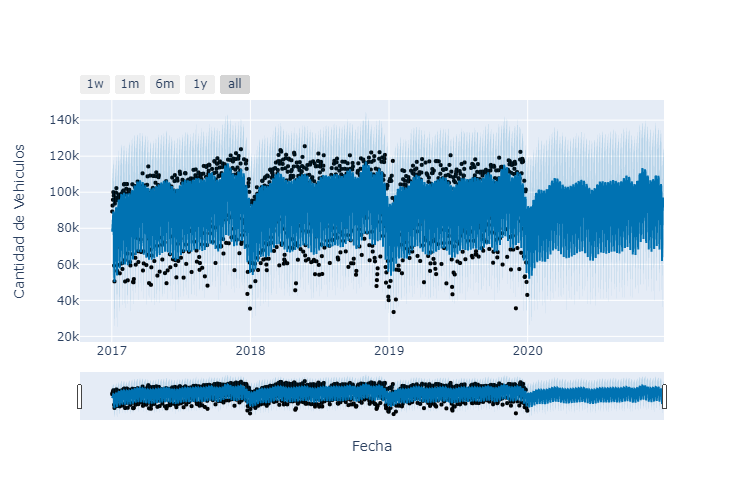

In [66]:
plot_plotly(m,forecast,figsize=(700,500),xlabel="Fecha",ylabel="Cantidad de Vehiculos")


En el grafico anterior podemos observar como podemos obtener los resultados para el año 2020 nos muestra una tendencia similar a lo que ocurre con periodos anteriores como la caida que se presenta cada año al igual que los picos que se presentan en ciertos meses especificos, aunque no considero que sea un buen predictor debido a que en muchos casos se encuentra subestimando y sobrevalorando los datos reales vs los predichos, asi que no utilizaria este modelo para crear una prediccion en el futuro porque posiblemente sus valores no me acerquen a una realidad.

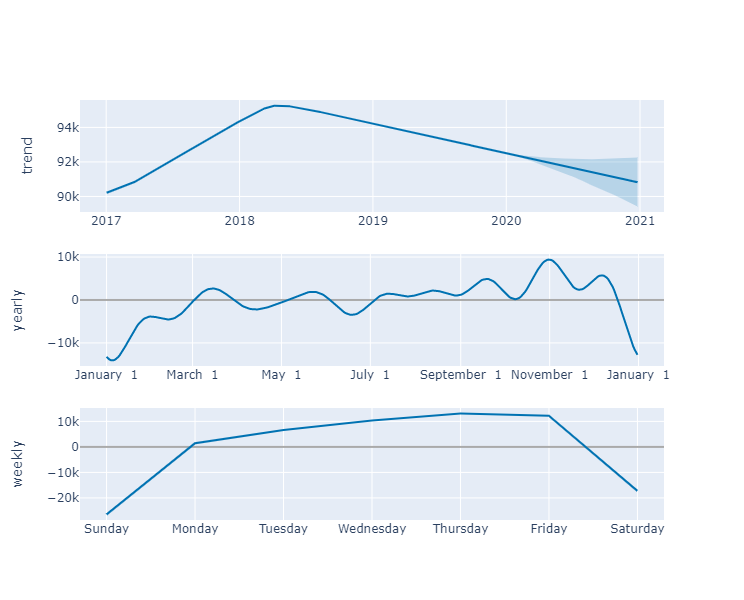

In [74]:
plot_components_plotly(m,forecast,figsize=(700,200))

En este ultimo grafico podemos observar como se comportan los datos de manera estacional tenemos inicialmente la tendencia y podemos observar que viene decreciendo aligual que tenemos la estacionalidad anual podemos deeducir que al principio de todos los años el flujo vehicular es minimo y va ascendiendo durante el transcurso de los meses hasta que al final del año por posibles festividades el flujo disminuye, este mismo patron lo podemos eviedenciar en la estacionalidad semanal donde los dias domingos es el dia que presenta menos flujo vehicular y este va incrementando atraves de la semana posiblemente por los horarios laborales y el desplazamiento de las personas del trabajo al hogar.